# Desarrollo con la base de datos Reactome
En este cuaderno se recoge parte del proceso de desarrollo del Trabajo de Fin de Master. En concreto, se desarrolla la parte final del proyecto.

In [ ]:
# Para evitar errores de versiones se utiliza la version de tensorflow empleada en el momento del desarrollo
!pip install tensorflow==2.15
!pip install python-dotenv
!pip install scanpy
!pip install scikit-misc
!pip install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

## Fuente de datos

In [ ]:
!git clone https://github.com/babelomics/ivae_scorer.git

Cloning into 'ivae_scorer'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 176 (delta 21), reused 35 (delta 10), pack-reused 119 (from 1)
Receiving objects: 100% (176/176), 72.16 MiB | 22.51 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
!pip install git+https://github.com/babelomics/ivae_scorer@develop

  Cloning https://github.com/babelomics/ivae_scorer (to revision develop) to /tmp/pip-req-build-jg17xey9
  Running command git clone --filter=blob:none --quiet https://github.com/babelomics/ivae_scorer /tmp/pip-req-build-jg17xey9
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/babelomics/ivae_scorer to commit 0f67d04a77ec157a02d74f249d6456253ec7e4ce
  Preparing metadata (setup.py) ... done
  Created wheel for ivae_scorer: filename=ivae_scorer-1.0.0-py3-none-any.whl size=528704 sha256=9c8064c78e894ac213907a6bbf6cd78a533c45d4d4c4afb95d87b91f35dc0e59
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkil09iu/wheels/f5/d0/86/8a998baa74d32887348c7f9fe7c15a843cd2cf4670f641d2fe
Successfully built ivae_scorer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from ivae_scorer.bio import (
    build_hipathia_renamers,
    get_adj_matrices,
    get_reactome_adj,
    sync_gexp_adj
)
from ivae_scorer.datasets import load_kang
from ivae_scorer.utils import set_all_seeds
from ivae_scorer.models import build_reactome_vae

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [ ]:
# %%
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

# %%

model_kind = "binn-reactome"
debug = 1
seed = 42
model_kind = str(model_kind)
debug = bool(int(debug))
seed = int(seed)

# Ajustar la ruta a los archivos
project_path = Path("/content/drive/MyDrive/TFM/EntregaFinal")
data_path = project_path.joinpath("Datos")
data_path.mkdir(exist_ok=True, parents=True)
mygene_path = data_path.joinpath("mygene")
mygene_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=seed)

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

print(f"{debug=} {model_kind=}")

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13
debug=True model_kind='binn-reactome'


In [ ]:
adata = load_kang(data_folder=data_path, normalize=False, n_genes=4000)

In [ ]:
x_trans = adata.to_df()

In [ ]:
# Obtener la matriz de pathways
reactome = get_reactome_adj()

reactome.head()

geneset,REACTOME_2_LTR_CIRCLE_FORMATION,REACTOME_ABACAVIR_METABOLISM,REACTOME_ABACAVIR_TRANSMEMBRANE_TRANSPORT,REACTOME_ABACAVIR_TRANSPORT_AND_METABOLISM,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,REACTOME_ABC_TRANSPORTERS_IN_LIPID_HOMEOSTASIS,REACTOME_ABC_TRANSPORTER_DISORDERS,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS,REACTOME_ABERRANT_REGULATION_OF_MITOTIC_G1_S_TRANSITION_IN_CANCER_DUE_TO_RB1_DEFECTS,REACTOME_ABORTIVE_ELONGATION_OF_HIV_1_TRANSCRIPT_IN_THE_ABSENCE_OF_TAT,...,REACTOME_WNT5A_DEPENDENT_INTERNALIZATION_OF_FZD2_FZD5_AND_ROR2,REACTOME_WNT5A_DEPENDENT_INTERNALIZATION_OF_FZD4,REACTOME_WNT_LIGAND_BIOGENESIS_AND_TRAFFICKING,REACTOME_WNT_MEDIATED_ACTIVATION_OF_DVL,REACTOME_XENOBIOTICS,REACTOME_YAP1_AND_WWTR1_TAZ_STIMULATED_GENE_EXPRESSION,REACTOME_ZBP1_DAI_MEDIATED_INDUCTION_OF_TYPE_I_IFNS,REACTOME_ZINC_EFFLUX_AND_COMPARTMENTALIZATION_BY_THE_SLC30_FAMILY,REACTOME_ZINC_INFLUX_INTO_CELLS_BY_THE_SLC39_GENE_FAMILY,REACTOME_ZINC_TRANSPORTERS
genesymbol,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4GNT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_trans, reactome = sync_gexp_adj(gexp=x_trans, adj=reactome)

In [ ]:
x_trans.shape, reactome.shape

((24673, 7573), (7573, 1615))

In [ ]:
obs = adata.obs.copy()

x_train, x_test = train_test_split(
    x_trans.apply(minmax_scale),
    test_size=0.33,
    stratify=obs["cell_type"],
    random_state=42,
)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [ ]:
x_train.shape, reactome.shape

((16530, 7573), (7573, 1615))

In [ ]:
vae, encoder, decoder = build_reactome_vae(reactome, seed)

In [16]:
batch_size = 32

callback = callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-1,
    patience=30,
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)
history = vae.fit(
    x_train.values,
    shuffle=True,
    verbose=1,
    epochs=100,
    batch_size=batch_size,
    callbacks=[callback, tensorboard_callback],
    validation_data=(x_test.values, None),
)

Epoch 1/100
517/517 [==============================] - 469s 905ms/step - loss: 10.1585 - mse: 0.0000e+00 - val_loss: 10.1432 - val_mse: 0.0000e+00
Epoch 2/100
517/517 [==============================] - 440s 851ms/step - loss: 10.1581 - mse: 0.0000e+00 - val_loss: 10.1390 - val_mse: 0.0000e+00
Epoch 3/100
517/517 [==============================] - 441s 853ms/step - loss: 10.1575 - mse: 0.0000e+00 - val_loss: 10.1391 - val_mse: 0.0000e+00
Epoch 4/100
517/517 [==============================] - 439s 849ms/step - loss: 10.1587 - mse: 0.0000e+00 - val_loss: 10.1385 - val_mse: 0.0000e+00
Epoch 5/100
517/517 [==============================] - 441s 854ms/step - loss: 10.1572 - mse: 0.0000e+00 - val_loss: 10.1379 - val_mse: 0.0000e+00
Epoch 6/100
517/517 [==============================] - 448s 866ms/step - loss: 10.1543 - mse: 0.0000e+00 - val_loss: 10.1390 - val_mse: 0.0000e+00
Epoch 7/100
517/517 [==============================] - 441s 854ms/step - loss: 10.1556 - mse: 0.0000e+00 - val_loss: 1

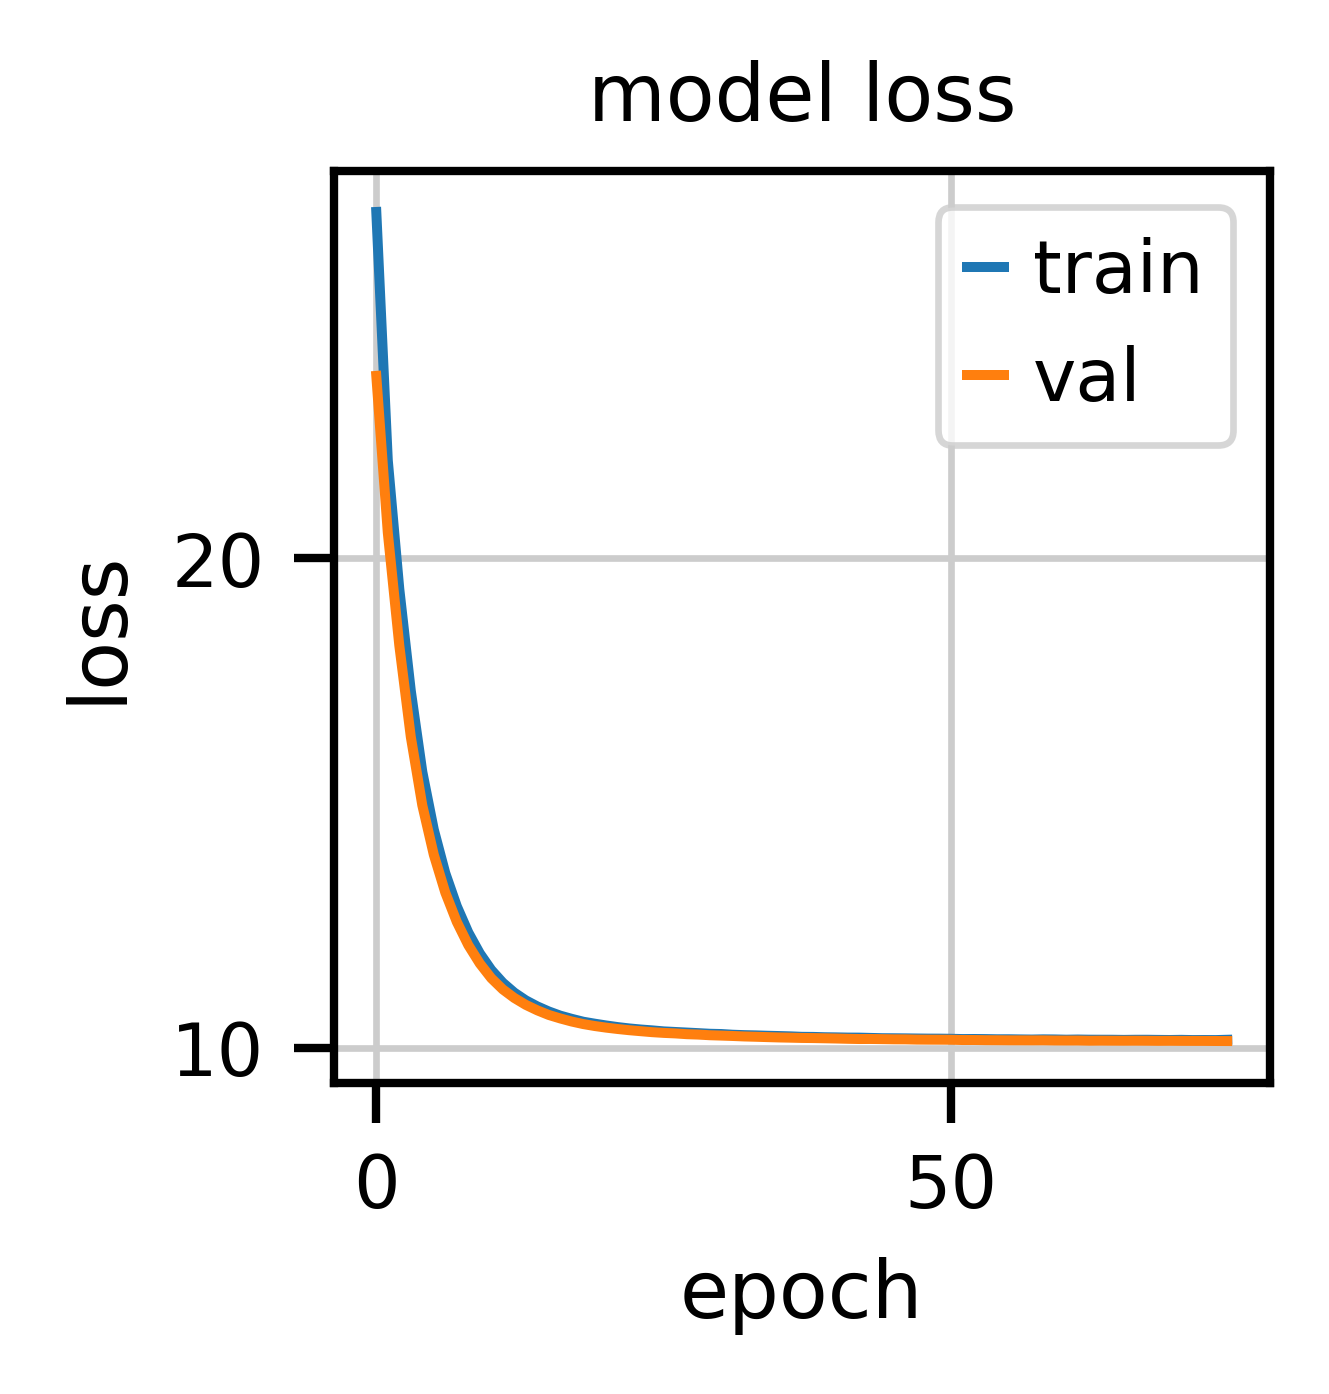

In [17]:
with sns.plotting_context("paper"):
    history.history.keys()
    # summarize history for loss
    plt.figure(figsize=(2, 2))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")

In [ ]:
x_train_encoded = encoder.predict(x_train, batch_size=batch_size)[0]
x_train_encoded = pd.DataFrame(x_train_encoded, index=x_train.index)

adata = sc.AnnData(X=x_train_encoded)
adata.obs = obs.loc[x_train.index]

# sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep="X", random_state=42)
sc.tl.leiden(adata, random_state=42)
sc.tl.umap(adata, random_state=42)

In [19]:
layer_outputs = [layer.output for layer in encoder.layers]
activation_model = Model(inputs=encoder.input, outputs=layer_outputs)

In [ ]:
layer_id = 1

entitie_names = reactome.columns.str.replace("REACTOME_", "").str.replace("_", " ")

x_train_encoded = activation_model.predict(x_train, batch_size=batch_size)[layer_id]
x_train_encoded = pd.DataFrame(
    x_train_encoded, index=x_train.index, columns=entitie_names
)

entities_adata = sc.AnnData(X=x_train_encoded.abs())
entities_adata.obs = obs.loc[x_train.index]

# sc.pp.log1p(adata)
sc.pp.neighbors(entities_adata, use_rep="X", random_state=42)
sc.tl.leiden(entities_adata, random_state=42)
sc.tl.umap(entities_adata, random_state=42)

In [21]:
adata.obsm["pathways"] = x_train_encoded.abs()

In [ ]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=1,
    wspace=0.3,
    show=False,
)

In [ ]:
sc.pl.umap(adata, color='leiden', show=False)

In [24]:
adata.obs["cell_type"].unique()

['NK cells', 'CD14+ Monocytes', 'B cells', 'CD4 T cells', 'CD8 T cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells',
                         'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [25]:
cell_types = adata.obs['cell_type'].unique()

n_types = len(cell_types)
n_cols = 2
n_rows = int(np.ceil(n_types / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, cell_type in enumerate(cell_types):
    subset = adata[adata.obs['cell_type'] == cell_type]

    sc.pl.umap(
        subset,
        color='condition',
        ax=axes[i],
        frameon=False,
        title=f'UMAP for {cell_type}',
        show=False
    )
    axes[i].set_title(f'UMAP for {cell_type}')
    axes[i].legend(title='Condition')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
fig.savefig('umap_by_cell_type.png', dpi=300)